Investigate the given dataset.

Generate a map.

## Application Parameters

Note: algorithm tuning is done with declaration of the model.

In [ ]:
import pandas as pd
import datetime
from datetime import date

In [ ]:
debug = False

DRIVE_PATH = "/content/drive/MyDrive/data606/"

# Set the location of this script in GDrive
SCRIPT_PATH = DRIVE_PATH + "src/"

# Root Path of the data on the cloud drive
DATA_PATH = DRIVE_PATH + "data/"

# Number of samples to work with - will be split  into train/test
SAMPLE_SIZE = 5000

# Ratio of test data to train data - used for split
TEST_RATIO = 0.3

# Device to run on
run_on_device =  'cpu' # 'cuda'

# Start including data from this date
START_DATE =  date.fromisoformat('1950-01-01')
# Stop including data after this date
END_DATE = date.fromisoformat('2022-12-31')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)
import yfinance as yf
yf.pdr_override()
import datetime
from datetime import date
import warnings

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
%matplotlib inline

---

**Initial Data Load**

---

### NOAA Data


In [ ]:
df = pd.read_csv(DATA_PATH + 'GlobalLandTemperaturesByCity.csv')

In [ ]:
print(df.shape)
df.describe().T

(8599212, 7)


,count,mean,std,min,25%,50%,75%,max
AverageTemperature,8235082.0,16.727433,10.353442,-42.704,10.299,18.831,25.210,39.651
AverageTemperatureUncertainty,8235082.0,1.028575,1.129733,0.034,0.337,0.591,1.349,15.396


In [ ]:
df.info()
df.tail(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
8599209,2013-07-01,18.775,0.193,Zwolle,Netherlands,52.24N,5.26E
8599210,2013-08-01,18.025,0.298,Zwolle,Netherlands,52.24N,5.26E
8599211,2013-09-01,NaN,NaN,Zwolle,Netherlands,52.24N,5.26E


In [ ]:
# convert to date
df['date'] = pd.to_datetime(df['dt']).dt.date
df['date'][3191], START_DATE

(datetime.date(2009, 10, 1), datetime.date(1950, 1, 1))

In [ ]:
# Truncate by date
df = df[df['date'] >= START_DATE]
df = df[df['date'] <= END_DATE]

In [ ]:
# Unique vals
df['City'].value_counts()

Rongcheng      2295
Springfield    2295
Worcester      2295
Santiago       2295
León           2295
               ... 
Hengyang        765
Henzada         765
Herat           765
Hermosillo      765
Zwolle          765
Name: City, Length: 3448, dtype: int64

In [ ]:
df['Country'].value_counts()

India            299115
China            290700
United States    196605
Brazil           168300
Japan            133875
                  ...  
Slovenia            765
Bahrain             765
Swaziland           765
Lesotho             765
Namibia             765
Name: Country, Length: 159, dtype: int64

In [ ]:
# For mapping we need to convert lat/lon into proper decimal floats
# where...
# - N/S - N remains positive, S becomes negative
# - E/W - E remains positive, W becomes negative

In [ ]:
# Remove S and add leading negative
df['Latitude'] = df['Latitude'].apply(lambda s: f'-{s}'[:-1] if s[-1] == 'S' else s)
# Remove N
df['Latitude'] = df['Latitude'].apply(lambda s: s[:-1] if s[-1] == 'N' else s)

In [ ]:
# Remove W and add leading negative
df['Longitude'] = df['Longitude'].apply(lambda s: f'-{s}'[:-1] if s[-1] == 'W' else s)
# Remove E
df['Longitude'] = df['Longitude'].apply(lambda s: s[:-1] if s[-1] == 'E' else s)

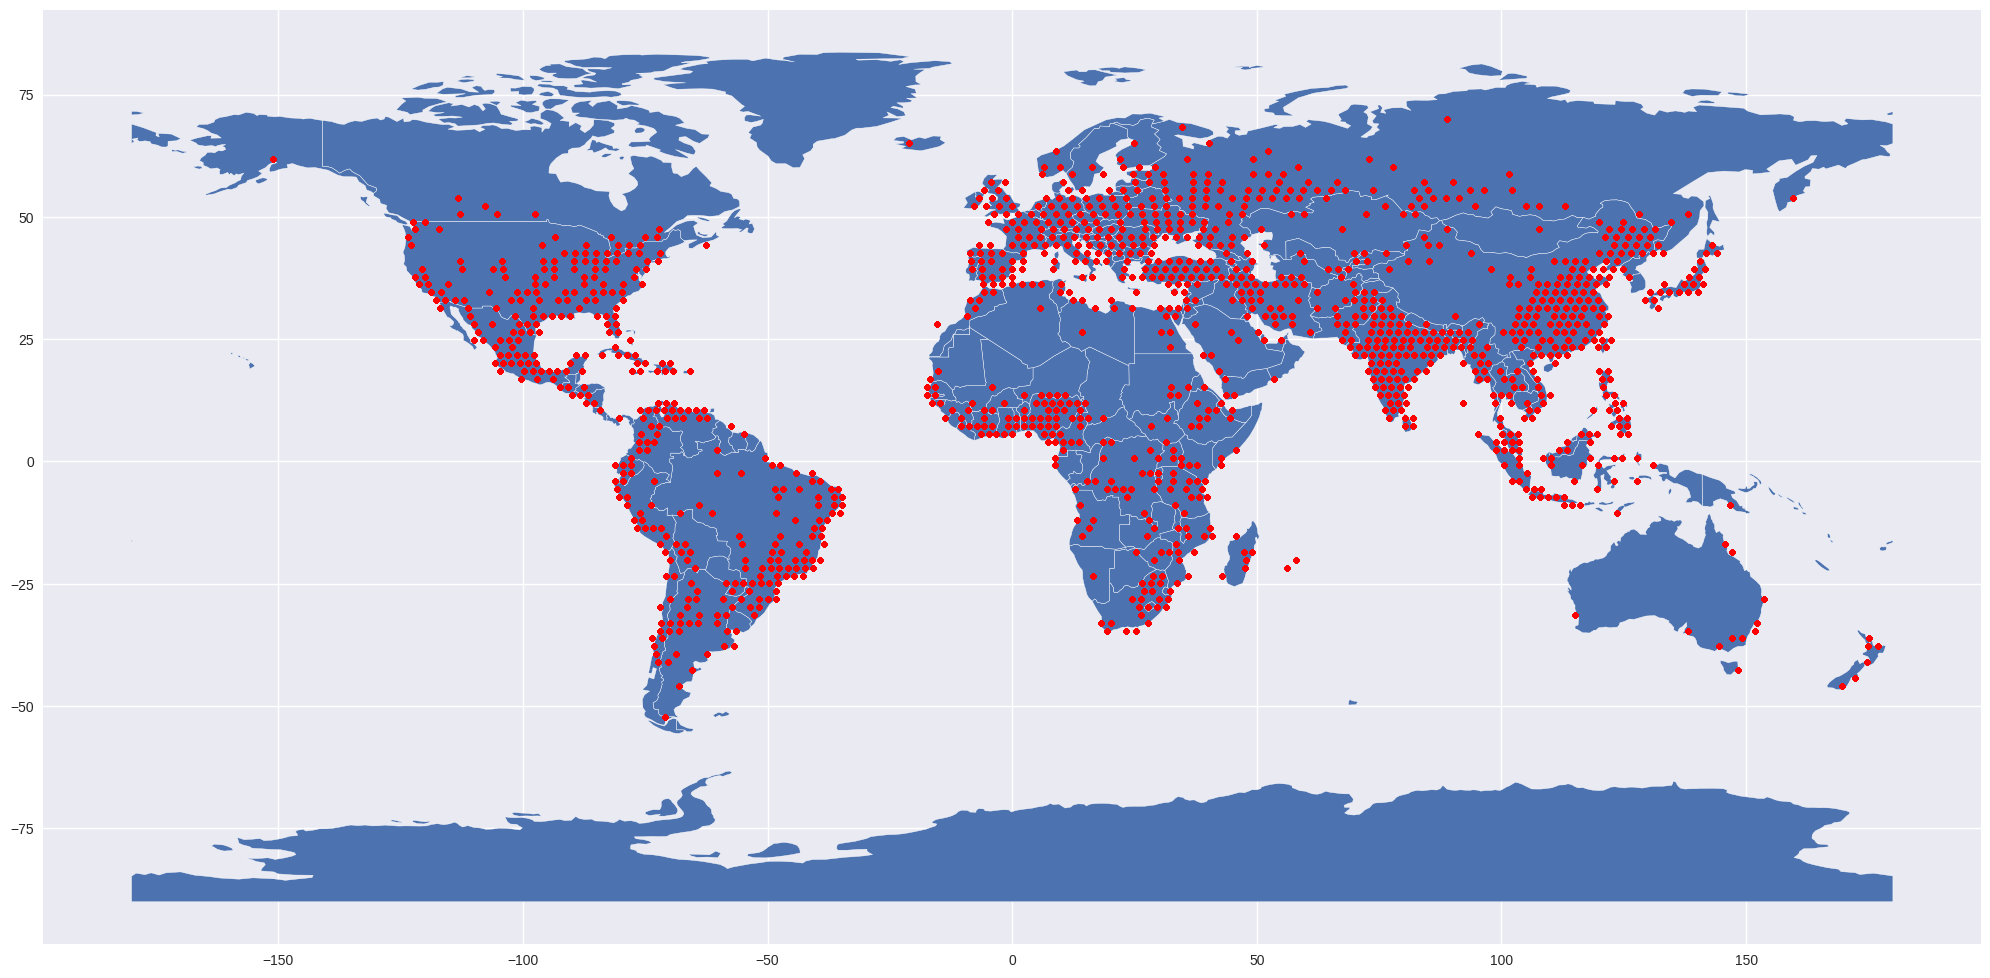

In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# Create array of lon/lat Points
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(25, 25)), marker='o', color='red', markersize=15);